In [3]:
from utils import *
from torch import nn
from tqdm import tqdm
from gym.core import Env
from itertools import product
from collections import deque

import optuna
import random
import torch.nn.functional as F
import torch
import math
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.patches as mpatches

## <b> 1.1 Defining training agent for model based on hyperparameters chosen </b>

In [8]:
def train(ARCHITECTURE, EPSILON, LEARNING_RATE, ACTIVATION_FUNCTION, OPTIMISER, BATCH_BUFFER, RUNS = 10, EPISODES = 200):  
    
    runs_results = []
    env = gym.make('CartPole-v1')
    
    BATCH_SIZE = BATCH_BUFFER[0]
    BUFFER_SIZE = BATCH_BUFFER[1]
    
    for _ in tqdm(range(RUNS)):
        policy_net = DQN(ARCHITECTURE, ACTIVATION_FUNCTION)
        target_net = DQN(ARCHITECTURE, ACTIVATION_FUNCTION)
        update_target(target_net, policy_net)
        target_net.eval()
        epsilon = EPSILON
        
        
        if OPTIMISER == 'Adam':
            optimiser = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
        elif OPTIMISER == 'SGD':
            optimiser = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
        
        else:
            return

        memory = ReplayBuffer(BUFFER_SIZE)

        episode_durations = []

        for i_episode in range(EPISODES):

            observation, _ = env.reset()
            state = torch.tensor(observation).float()
            done = False
            terminated = False 
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, _ = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < BATCH_SIZE:
                    transitions = memory.sample(BATCH_SIZE)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimiser.zero_grad()
                    mse_loss.backward()
                    optimiser.step()
                
                if epsilon < 0.01: #Arbitrary small value to stop the decay
                    epsilon = 0.01
                else:
                    epsilon = epsilon*0.99 
                    
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
                    
            # Update the target network, copying all weights and biases in DQN
            if i_episode % 1 == 0: 
                update_target(target_net, policy_net)
                
            
        runs_results.append(episode_durations)
     

    return runs_results


## <b> 1.2 Defining OPTUNA study </b>

In [9]:
def objective(trial):
    
    ARCHITECTURE = trial.suggest_categorical('architecture', [ 
        [4, 32, 2], 
        [4, 64, 2],
        [4, 128, 2],
        [4, 32, 32, 2],
        [4, 64, 32, 2], 
        [4, 64, 64, 2],
        [4, 64, 128, 2],   
        [4, 128, 128, 2] 
    ])
    
    EPSILON = trial.suggest_categorical("epsilon", [0, 0.3, 0.5, 0.9, 1]) 
    LEARNING_RATE = trial.suggest_categorical("lr", [0.001, 0.01, 0.1])
    ACTIVATION_FUNCTION = trial.suggest_categorical('activation_function',[F.mish, F.tanh, F.relu,  F.leaky_relu])
    OPTIMISER= trial.suggest_categorical('optimiser', ['SGD', 'Adam'])
    
    BATCH_SIZE = [5, 10, 15, 20]
    BUFFER_SIZE = [5000, 10000, 15000, 20000]   
    BATCH_BUFFER_ARRAY = [(batch_size, buffer_size) for batch_size, buffer_size in product(BATCH_SIZE, BUFFER_SIZE) if batch_size <= buffer_size]
    BATCH_BUFFER = trial.suggest_categorical('batch_size_buffer_size', BATCH_BUFFER_ARRAY)

    #update target network
    runs_results = train(ARCHITECTURE, EPSILON, LEARNING_RATE, ACTIVATION_FUNCTION, OPTIMISER, BATCH_BUFFER)
    
    results = torch.tensor(runs_results)
    mean = results.float().mean(0)
    return -(np.count_nonzero(mean.detach().numpy()>100))

def optuna_study(n_trials):
    study = optuna.create_study(study_name="tuning")
    study.optimize(objective, n_trials=n_trials)
    trial = study.best_trial
    
    print("Best performance:")
    print("Score: ", trial.value)

    print("Optimal hyperparameters: ")
    for key, value in trial.params.items():
        print("{}: {}".format(key, value))

In [ ]:
optuna_study(n_trials = 500)

[I 2023-11-19 21:55:13,305] A new study created in memory with name: tuning
100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.71s/it]
[I 2023-11-19 21:55:50,494] Trial 0 finished with value: -2.0 and parameters: {'architecture': [4, 64, 64, 2], 'epsilon': 0.5, 'lr': 0.001, 'activation_function': <function leaky_relu at 0x7f7aea17d0d0>, 'optimiser': 'SGD', 'batch_size_buffer_size': (15, 20000)}. Best is trial 0 with value: -2.0.
100%|███████████████████████████████████████████| 10/10 [10:27<00:00, 62.71s/it]
[I 2023-11-19 22:06:17,586] Trial 1 finished with value: -151.0 and parameters: {'architecture': [4, 32, 32, 2], 'epsilon': 0.9, 'lr': 0.001, 'activation_function': <function mish at 0x7f7aea17d820>, 'optimiser': 'Adam', 'batch_size_buffer_size': (20, 5000)}. Best is trial 1 with value: -151.0.
 20%|████████▊                                   | 2/10 [02:02<08:33, 64.24s/it]

## <b> 1.3 Training optimised model based on hyperparameter search results </b>

In [33]:
#Train optimised version and fetch results over 300 episodes

results_final = train(
                        ARCHITECTURE = [4, 64, 64, 2],
                        EPSILON= 0.9,
                        LEARNING_RATE= 0.001,
                        ACTIVATION_FUNCTION= F.leaky_relu, 
                        OPTIMISER= 'Adam', 
                        BATCH_BUFFER= [20,15000],
                        EPISODES= 300,
                        RUNS= 10
                    )


100%|██████████████████████████████████████████| 10/10 [26:45<00:00, 160.55s/it]


## <b> 1.4 Training unoptimised model for comparison</b>

In [25]:
#Train  unoptimised version for comparison
EPSILON_unopt = 1
NUM_RUNS = 10

runs_results_unoptimised = []
env = gym.make('CartPole-v1')

for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4,2], F.relu)
    target_net = DQN([4,2], F.relu)
    update_target(target_net, policy_net)
    target_net.eval()
    
    optimizer = optim.SGD(policy_net.parameters(), lr=1.)
    memory = ReplayBuffer(1)

    steps_done = 0

    episode_durations = []

    for i_episode in range(300):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 300)

        observation, _ = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON_unopt, policy_net, state)

            observation, reward, done, terminated, _ = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < 1:
                transitions = memory.sample(1)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 1 == 0: 
            update_target(target_net, policy_net)
    runs_results_unoptimised.append(episode_durations)
print('Complete')

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

## <b> Question 1.2: Plotting learning curve of optimised model </b>

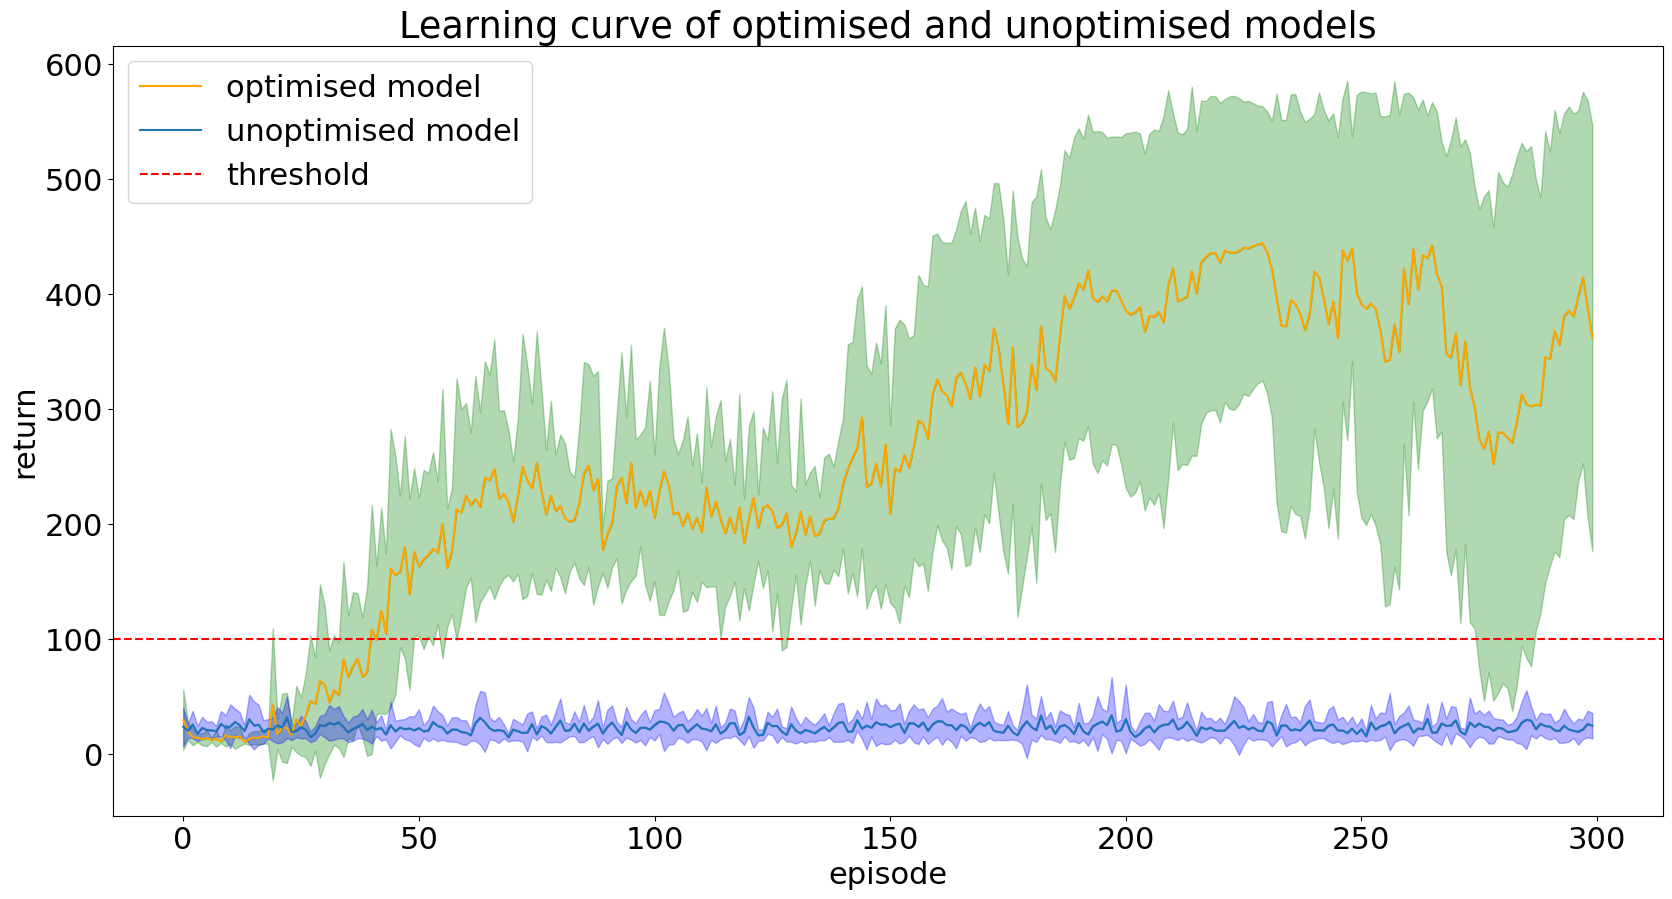

In [34]:
# Plotting the learning curve
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})

results_unoptimised = torch.tensor(runs_results_unoptimised)
means_unoptimised = results_unoptimised.float().mean(0)
stds_unoptimised = results_unoptimised.float().std(0)

results_optimised = torch.tensor(results_final)
means_optimised = results_optimised.float().mean(0)
stds_optimised = results_optimised.float().std(0)

plt.plot(torch.arange(300), means_optimised, label = "optimised model", color='orange')
plt.fill_between(np.arange(300), means_optimised, means_optimised+stds_optimised, alpha=0.3, color='green')
plt.fill_between(np.arange(300), means_optimised, means_optimised-stds_optimised, alpha=0.3, color='green')

plt.plot(torch.arange(300), means_unoptimised, label = "unoptimised model")
plt.fill_between(np.arange(300), means_unoptimised, means_unoptimised+stds_unoptimised, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_unoptimised, means_unoptimised-stds_unoptimised, alpha=0.3, color='b')
plt.axhline(y = 100, color = 'r', linestyle = '--', label = 'threshold')


plt.legend(loc='upper left')
plt.ylabel("return")
plt.xlabel("episode")
plt.title("Learning curve of optimised and unoptimised models")

plt.show()

## <b> Question 2: Visualising DQN policy </b>

## <b> Storing resulting DQN policy</b>

In [35]:
def train_policy(ARCHITECTURE, EPSILON, LEARNING_RATE, ACTIVATION_FUNCTION, OPTIMISER, BATCH_BUFFER, EPISODES,RUNS):  
    
    runs_results = []
    env = gym.make('CartPole-v1')
    
    BATCH_SIZE = BATCH_BUFFER[0]
    BUFFER_SIZE = BATCH_BUFFER[1]
    
    for _ in tqdm(range(RUNS)):
        
        policy_net = DQN(ARCHITECTURE, ACTIVATION_FUNCTION)
        target_net = DQN(ARCHITECTURE, ACTIVATION_FUNCTION)
        update_target(target_net, policy_net)
        target_net.eval()
        epsilon = EPSILON
        
        
        if OPTIMISER == 'Adam':
            optimiser = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
        elif OPTIMISER == 'SGD':
            optimiser = optim.SGD(policy_net.parameters(), lr=LEARNING_RATE)
        
        else:
            return

        memory = ReplayBuffer(BUFFER_SIZE)

        episode_durations = []

        for i_episode in range(EPISODES):

            observation, _ = env.reset()
            state = torch.tensor(observation).float()
            t = 0
            
            done = False
            terminated = False 
            
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, _ = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < BATCH_SIZE:
                    transitions = memory.sample(BATCH_SIZE)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimiser.zero_grad()
                    mse_loss.backward()
                    optimiser.step()
                
                if epsilon < 0.01:
                    epsilon = 0.01 # Arbitrary small value
                else:
                    epsilon = epsilon*0.99 #Decaying epsilon
                    
                    
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

                    
            # Update the target network, copying all weights and biases in DQN
            if i_episode % 1 == 0: 
                update_target(target_net, policy_net)
                
            
        runs_results.append(episode_durations)
     

    return policy_net

policy_net = train_policy(
                        ARCHITECTURE = [4, 64, 64, 2],
                        EPSILON= 0.9,
                        LEARNING_RATE= 0.001,
                        ACTIVATION_FUNCTION= F.leaky_relu, 
                        OPTIMISER= 'Adam', 
                        BATCH_BUFFER= [20,15000],
                        EPISODES= 300,
                        RUNS= 1
                        )

100%|████████████████████████████████████████████| 1/1 [03:04<00:00, 184.38s/it]


## <b> Question 2: Plot function </b>

In [36]:
def plot(policy_net, speed, q, title):
    
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(10,5))
    
    angle_range = .2095 # you may modify this range
    omega_range = 2     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    
    q = q 
    
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., speed, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.colorbar()
        
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        patch_0 = mpatches.Patch(color='blue', label='Action 0: Push left')
        patch_1 = mpatches.Patch(color='yellow', label='Action 1: Push right')
        plt.legend(handles=[patch_0, patch_1]) 

    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.title(title)
    plt.show()

## <b>Question 2.1: Plotting DQN greedy policy slices</b>

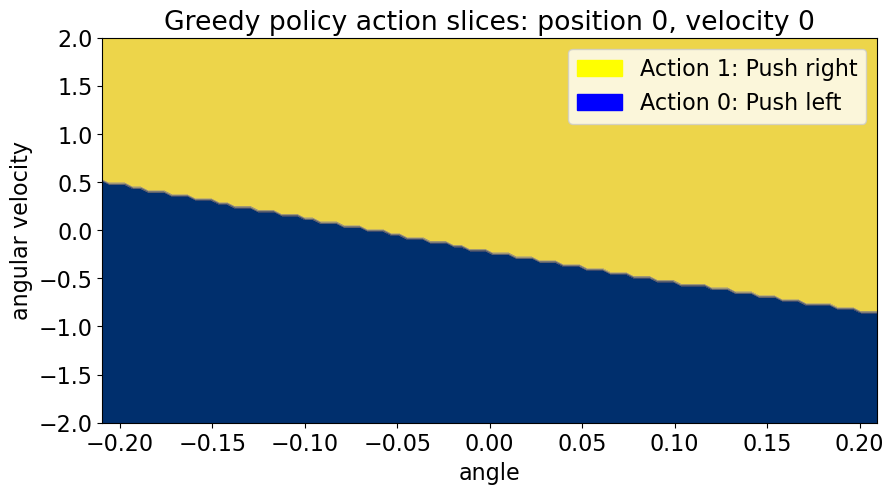

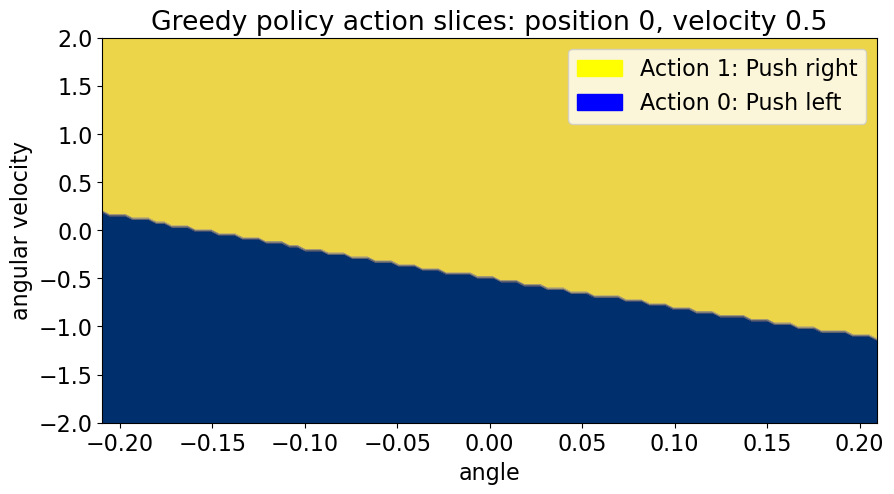

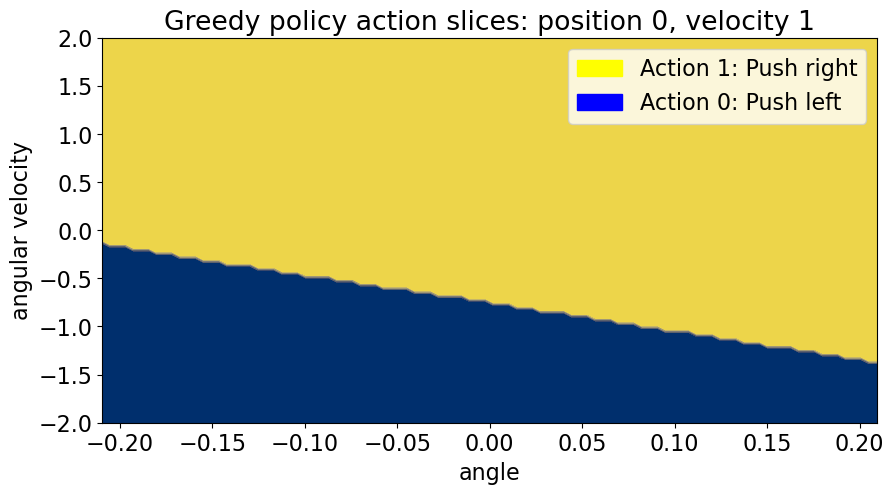

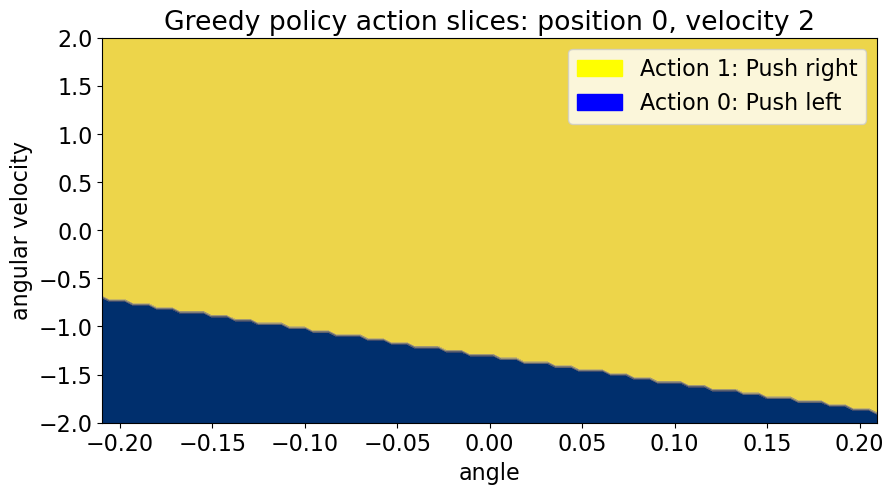

In [37]:
plot(policy_net, speed=0, q=False, title="Greedy policy action slices: position 0, velocity 0")
plot(policy_net, speed=0.5, q=False, title="Greedy policy action slices: position 0, velocity 0.5")
plot(policy_net, speed=1, q=False, title="Greedy policy action slices: position 0, velocity 1")
plot(policy_net, speed=2, q=False, title="Greedy policy action slices: position 0, velocity 2")

## <b> Question 2.2: Plotting DQN Q values </b>

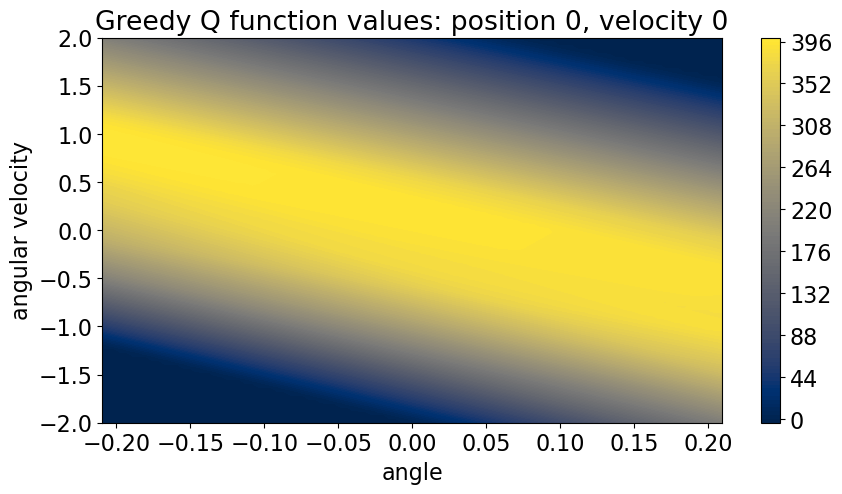

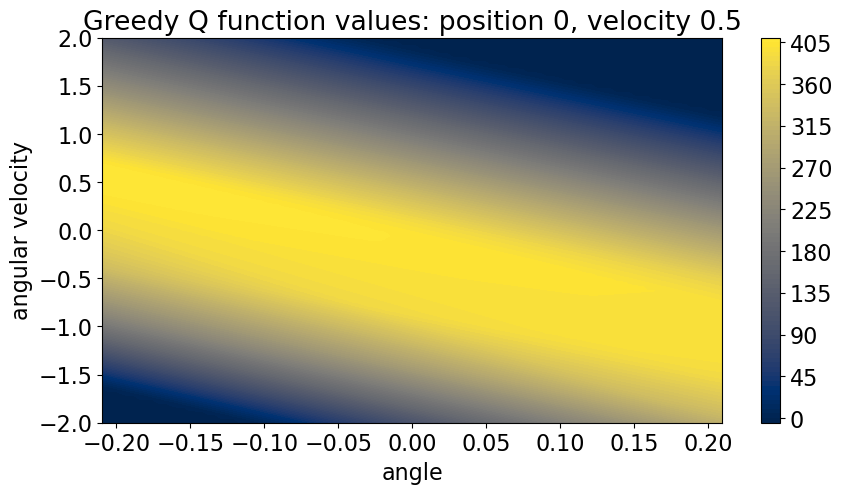

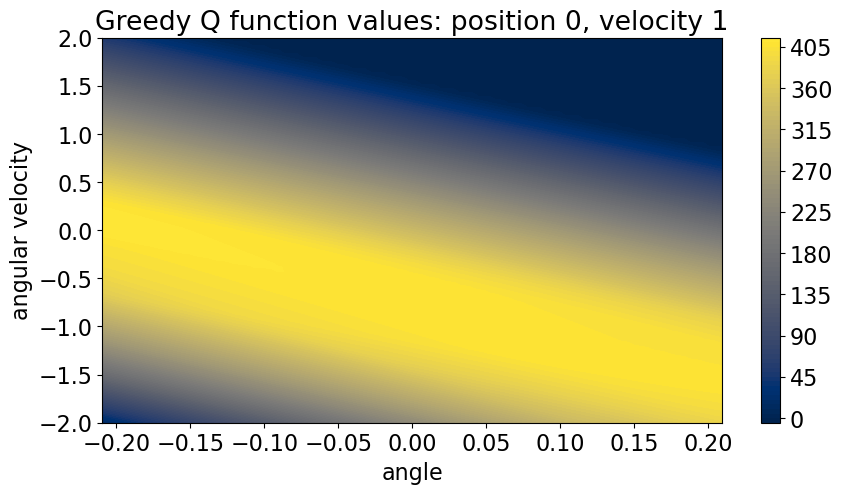

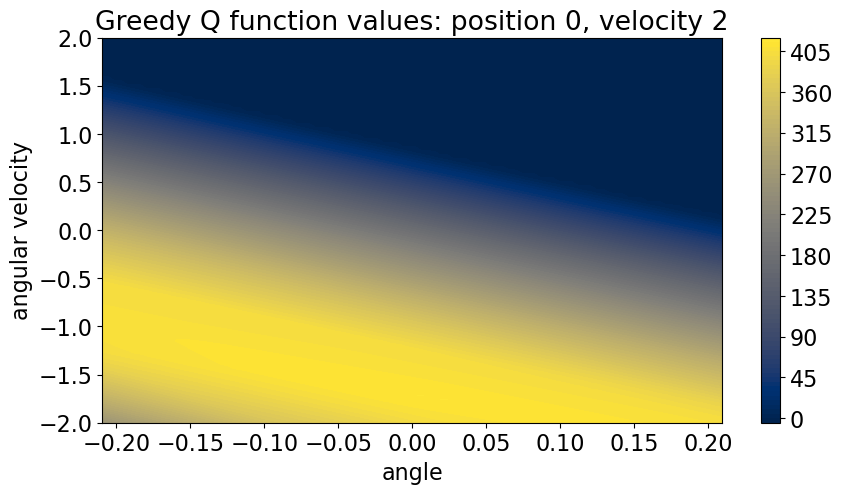

In [38]:
plot(policy_net, speed=0, q=True, title="Greedy Q function values: position 0, velocity 0")
plot(policy_net, speed=0.5, q=True, title="Greedy Q function values: position 0, velocity 0.5")
plot(policy_net, speed=1, q=True, title="Greedy Q function values: position 0, velocity 1")
plot(policy_net, speed=2, q=True, title="Greedy Q function values: position 0, velocity 2")